In [1]:
# load required packages
import nltk
from nltk.corpus import PlaintextCorpusReader
import pandas as pd
import re
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from __future__ import print_function
from sklearn.cluster import KMeans

[nltk_data] Downloading package stopwords to C:\Users\Mr.
[nltk_data]     Priyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining Functions

In [2]:
def print_cluster(df, km, num_clusters, cluster_level, num_cluster_topics=3, num_cluster_companies=2) :
    
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    for i in range(num_clusters):
        print("Cluster %d words:" % int(i), end='')

        for ind in range(0,num_cluster_topics): # top 6 words per cluster
            print(' %s' % terms[order_centroids[i,ind]], end=',')
        print() #add whitespace
        print() #add whitespace

        print("Cluster %d Companies:" % int(i), end='')
        #print()
        for title in df[df[cluster_level]==i]["Company"].sample(num_cluster_companies).values.tolist():
            print(' %s,' % title, end='')
            #uncomment below to see the Sector and Industry of each Company
            #print("Sector:",merged_df.Sector[merged_df.Company==title].values[0],"Industry:",merged_df.Industry[merged_df.Company==title].values[0])
        print() #add whitespace
        print() #add whitespace

    print("Split of classes within clusters:")
    print(df[cluster_level].value_counts())
    

In [3]:
def find_number_clusters(tfidf):
    import time
    wcss = []
    start = time.time()
    for i in range(1, 10):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 10)
        kmeans.fit(tfidf)
        wcss.append(kmeans.inertia_)
    end = time.time()
    print("execution time:",round(((end-start)/60),2),"minutes")
    plt.plot(range(1, 10), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()  

In [4]:
def apply_kmeans(num_clusters,random_state,tfidf):
    km = KMeans(n_clusters=num_clusters, random_state =random_state)
    km.fit(tfidf)
    clusters = km.labels_.tolist()
    return km,clusters

In [5]:
def freq_words(indexes,new_corpus,terms,X):
    cluster_descriptions=""
    for i in (indexes):
        cluster_descriptions = cluster_descriptions+new_corpus[i]+" "
    cluster_descriptions=cluster_descriptions[:-1]
    from collections import Counter
    Counter = Counter(cluster_descriptions.split())
    #freq_words has most commonly occuring words within parent cluster ranked in descending order
    freq_words=Counter.most_common()
    # freq_terms has most commonly occuring terms(from tfidf matrix) within parent cluster ranked in descending order along with 
    #frequencies
    freq_terms_with_count = []
    for word in freq_words:
        if word[0] in set(terms):
            freq_terms_with_count.append(word)
    #sorted list of most occuring terms in cluster 3 , subcluster 1
    freq_terms = []
    for i in range(len(freq_terms_with_count)):
        freq_terms.append(freq_terms_with_count[i][0])
    # top X most occuring terms from that cluster
    # here is where you can play around with the X value
    X_freq_terms=freq_terms[0:X]
    return X_freq_terms, freq_terms_with_count   

In [6]:
def print_cluster_words(df, km, num_clusters, cluster_level, words, num_cluster_topics=3, num_cluster_companies=2) :
    
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    for i in range(num_clusters):
        print("Cluster %d words:" % int(i), end='')
        #for ind in range(num_cluster_topics): # top 6 words per cluster
            #check_word = terms[order_centroids[i,ind]]
            #if check_word not in set(words):
                #print(' %s' % check_word, end=',')
            #else:
                # run ind for one more loop
                #continue
        flag=0
        ind=0
        while flag < num_cluster_topics: # top n words per cluster
            check_word = terms[order_centroids[i,ind]]
            if check_word not in set(words):
                print(' %s' % check_word, end=',')
                flag=flag+1
                ind = ind+1
            else:
                ind = ind+1
                    
        print() #add whitespace
        print() #add whitespace

        print("Cluster %d Companies:" % int(i), end='')
        #print()
        for title in df[df[cluster_level]==i]["Company"].sample(num_cluster_companies).values.tolist():
            print(' %s,' % title, end='')
            #uncomment below to see the Sector and Industry of each Company
            #print("Sector:",merged_df.Sector[merged_df.Company==title].values[0],"Industry:",merged_df.Industry[merged_df.Company==title].values[0])
        print() #add whitespace
        print() #add whitespace

    print("Split of classes within clusters:")
    print(df[cluster_level].value_counts())
    

## Reading from the text files to create corpus

In [7]:
#change path below to folder where you place the files
corpus_path = "C:\\Users\\Mr. Priyan\\Dropbox\\Data Science\\DDL\\company_profiles" 
corpus = PlaintextCorpusReader(corpus_path, ".*\.txt")
print("Company Profile Corpus Statistics")
print("Number of profiles: " + str(len(corpus.fileids())))
print("Number of paragraphs: " + str(len(corpus.paras())))
print("Number of sentences: " + str(len(corpus.sents())))
print("Number of words: " + str(len(corpus.words())))

Company Profile Corpus Statistics
Number of profiles: 3558
Number of paragraphs: 3558
Number of sentences: 23988
Number of words: 790836


Changing to list of lists

In [5]:
list_corpus = []
#Converting corpus to list of lists
for i in range(0,len(corpus.fileids())):
    list_corpus.append(list(corpus.words(corpus.fileids()[i])))

## Preprocessing the corpus

Creating list of common words to later remove from the corpus

In [3]:
common_words = ['product','products','service','services','solution','solutions','segment','segments','offering','offerings',\
                'market','markets','provide','provides','provided','industry','industries','sells','sell','sold','state',\
                'states','headquarter','headquarters','headquartered', 'canada', 'california','texas','america','management',\
               'manages','manage', 'management','business','businesses','operation','operations','state','states',\
                'subsidiary','subsidiaries','approximate','approximately','group','groups','include','including','includes',\
                'base','bases','location','locations','use','uses','store','stores','unit','units','item','items',\
                'outlet','outlets','offer','offers','process','processes','processing','corporation','corporate','custom',\
               'offering','offerings','operate','operations','new york','africa','canada','america','international',\
                'manufacture','manufactures','manufacturer','manufacturers','brand','brands','benefit','benefits','customer',\
                'customers','industry','industries','firm','firms','commercial','commercials','com','new','speciality',\
                'specialities','used','unity','manufacturing','united','produce','produces','operates','operator','industrial',\
                'sales','company','companies','europe', 'asia','americas','middle east','sector','sectors','together',\
                'operators','production','productions','sale','private','public'\
               ]      
               
# to see the common words sorted in order
common_words.sort() 
#common_words      
               

 Pre-Processing Steps :-
- Removing punctuation
- Converting to lowercase
- Stemming
- Removing stop words
- Removing common words

In [62]:
# Preprocessing
#commenting everything as I had already saved new_corpus after the first time. 

import time
start = time.time()

new_corpus = []    
for i in range(0,len(list_corpus)):
    #remove punctuation
    review = re.sub('[^a-zA-Z]', ' ', str(list_corpus[i]))
    #convert all to lowercase
    review = review.lower()
    review = review.split()
    #stemming
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english')) if not word in set(common_words)]
    review = ' '.join(review)
    new_corpus.append(review)

end = time.time()
print("execution time:",round(((end-start)/60),2),"minutes")


execution time: 10.41 minutes


In [63]:
# to store the new_corpus list instead of having to run it each time 
#%store new_corpus 


Stored 'new_corpus' (list)


In [8]:
#restoring new_corpus which was stored already
%store -r 

In [9]:
#checking the content of a random document from new_corpus and comparing it to original description
import random
rand_num = random.randrange(1,3559,1)
print("Original description:")
print(' '.join(corpus.words(corpus.fileids()[rand_num])))
print()
print("After pre-processing:")
print(new_corpus[rand_num])
print()

Original description:
Bojangles ', Inc . develops , operates , and franchises limited service restaurants in the United States . Its restaurants offer made - from - scratch biscuit breakfast sandwiches , hand - breaded bone - in chicken , fixin ' s , and iced tea . As of December 31 , 2017 , the company operated 764 system - wide restaurants , including 325 company - operated and 439 franchised restaurants primarily located in the Southeastern United States . Bojangles ', Inc . was founded in 1977 and is headquartered in Charlotte , North Carolina .

After pre-processing:
bojangl inc develop franchis limit restaur restaur made scratch biscuit breakfast sandwich hand bread bone chicken fixin ice tea decemb oper system wide restaur oper franchis restaur primarili locat southeastern bojangl inc found charlott north carolina



## Feature Extraction

Using TF-IDF 

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
#original: max_df=0.8, min_df=0.05, max_features=200000
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.02, max_features=200000,
                                 stop_words='english',
                                 use_idf=True, tokenizer=None, ngram_range=(1,3))
#fit the vectorizer to corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(new_corpus) 

In [11]:
# to see shape of tfidf matrix
tfidf_matrix.shape

(3558, 735)

In [20]:
#tdidf feature names
terms = tfidf_vectorizer.get_feature_names()

In [137]:
terms

['accept',
 'access',
 'accessori',
 'account',
 'account certif',
 'account certif deposit',
 'account money',
 'account save',
 'account save account',
 'acquir',
 'acquisit',
 'acr',
 'activ',
 'acut',
 'ad',
 'addit',
 'address',
 'administr',
 'adult',
 'advanc',
 'advertis',
 'advisori',
 'aerospac',
 'agenc',
 'agent',
 'agreement',
 'agricultur',
 'air',
 'aircraft',
 'allow',
 'altern',
 'american',
 'analysi',
 'analyt',
 'annuiti',
 'anti',
 'apparel',
 'applianc',
 'applic',
 'april',
 'area',
 'arizona',
 'assembl',
 'assess',
 'asset',
 'assist',
 'associ',
 'atm',
 'australia',
 'auto',
 'autom',
 'autom teller',
 'automat',
 'automobil',
 'automot',
 'aviat',
 'balanc',
 'bancorp',
 'bank',
 'bank bank',
 'bank hold',
 'bank offic',
 'bank variou',
 'bar',
 'barrel',
 'base',
 'basin',
 'bear',
 'beverag',
 'biolog',
 'biopharmaceut',
 'biopharmaceut focus',
 'biotechnolog',
 'board',
 'bond',
 'box',
 'branch',
 'brand',
 'broker',
 'brokerag',
 'build',
 'cabl',
 'can

In [133]:
# Apply Kmeans Clustering
km, clusters = apply_kmeans(num_clusters=5,random_state=42,tfidf= tfidf_matrix)

In [12]:
# saving the clustering model
from sklearn.externals import joblib

#uncomment the below to save your model 
#joblib.dump(km,  '5clusters.pkl')
#since I've already run my model I am loading from the pickle
#Uncomment to load the model with 5 clusters
num_clusters = 5
km = joblib.load('5clusters.pkl')
clusters = km.labels_.tolist()

In [13]:
# creating a dataframe which contains additional information about each company
df = pd.read_csv("C:\\Users\\Mr. Priyan\\Dropbox\\Data Science\\DDL\\company_info.csv")
df.sample(5)

,Ticker,Company,Sector,Industry,Country
3383,INS,Intelligent Systems Corporation,Industrial Goods,Diversified Machinery,USA
3887,LHO,LaSalle Hotel Properties,Financial,REIT - Hotel/Motel,USA
3449,IRG,"Ignite Restaurant Group, Inc.",Services,Restaurants,USA
2789,GNTX,Gentex Corp.,Consumer Goods,Auto Parts,USA
2947,HCHC,"HC2 Holdings, Inc.",Technology,Long Distance Carriers,USA


In [14]:
# Creating a dataframe that contains the company ticker along with the cluster number
df_corpus = pd.DataFrame({'Ticker':corpus.fileids(), 'Clusters':clusters})
df_corpus.head(5)

,Clusters,Ticker
0,3,A-profile.txt
1,3,AA-profile.txt
2,3,AAC-profile.txt
3,3,AAL-profile.txt
4,3,AAMC-profile.txt


In [15]:
# Removing the "-profile.txt" from the Ticker
import re
for i in range(0,len(df_corpus)):
    df_corpus.loc[i,'Ticker']=re.sub("-profile.txt","",df_corpus.loc[i,'Ticker'])
df_corpus.head(5)

,Clusters,Ticker
0,3,A
1,3,AA
2,3,AAC
3,3,AAL
4,3,AAMC


In [16]:
# merging the two dataframe on the Ticker
merged_df = pd.merge(left=df, right=df_corpus, how='inner', on="Ticker")

In [17]:
merged_df.sample(5)

,Ticker,Company,Sector,Industry,Country,Clusters
2903,SKY,Skyline Corp.,Industrial Goods,Manufactured Housing,USA,3
1033,EGBN,"Eagle Bancorp, Inc.",Financial,Regional - Mid-Atlantic Banks,USA,2
1851,KVHI,KVH Industries Inc.,Technology,Communication Equipment,USA,3
3180,TRNS,Transcat Inc.,Technology,Scientific & Technical Instruments,USA,3
3477,WSBF,"Waterstone Financial, Inc.",Financial,Savings & Loans,USA,2


In [18]:
# Printing the most recurring Sector(taken from previous dataframe) in each cluster
for i in range(num_clusters):
    print("Cluster",i,":",merged_df[merged_df.Clusters==i].Sector.mode()[0],":- % correct categories is ", \
    round(len(merged_df[merged_df.Clusters==i][merged_df[merged_df.Clusters==i].Sector==\
    merged_df[merged_df.Clusters==i].Sector.mode()[0]])/len(merged_df[merged_df.Clusters==i])*100,2))   

Cluster 0 : Healthcare :- % correct categories is  98.8
Cluster 1 : Financial :- % correct categories is  95.0
Cluster 2 : Financial :- % correct categories is  99.2
Cluster 3 : Services :- % correct categories is  25.94
Cluster 4 : Basic Materials :- % correct categories is  68.84


In [21]:
# Printing terms per cluster
print_cluster(df=merged_df, km=km, num_clusters=num_clusters, num_cluster_topics=5, \
              num_cluster_companies=5, cluster_level='Clusters')

Top terms per cluster:

Cluster 0 words: treatment, clinic, develop, phase, diseas,

Cluster 0 Companies: Halozyme Therapeutics, Inc., AcelRx Pharmaceuticals, Inc., MEI Pharma, Inc., TrovaGene, Inc., Seres Therapeutics, Inc.,

Cluster 1 words: invest, fund, real estat, estat, real,

Cluster 1 Companies: Walter Investment Management Corp., Empire State Realty OP, L.P., National Retail Properties, Inc., Solar Capital Ltd., Franklin Street Properties Corp.,

Cluster 2 words: loan, bank, deposit, account, credit,

Cluster 2 Companies: OneMain Holdings, Inc., Citizens Community Bancorp, Inc., Two River Bancorp, BSB Bancorp, Inc. (Maryland), First Community Corporation,

Cluster 3 words: retail, applic, technolog, equip, design,

Cluster 3 Companies: Kemper Corporation, Bio-Rad Laboratories, Inc., U.S. Concrete, Inc., VSE Corp., Movado Group, Inc.,

Cluster 4 words: ga, oil, natur ga, natur, energi,

Cluster 4 Companies: Unit Corporation, CARBO Ceramics Inc., SM Energy Company, Cheniere Ener

# Splitting clusters 3, 4 & 1 into sub-clusters

### Splitting the biggest cluster , cluster 3

In [22]:
# trying to find subclusters for any cluster 
Subcluster3_df=merged_df[merged_df['Clusters']==3]
# to get only the indices for this cluster
cluster3_tfidif=tfidf_matrix[Subcluster3_df.index.values]
km,clusters = apply_kmeans(num_clusters = 4,random_state =10,tfidf = cluster3_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster3_df = Subcluster3_df.assign(Subclusters_level_1 = clusters)
# Printing terms per cluster
print_cluster(df=Subcluster3_df, km=km, num_clusters=4, num_cluster_topics=6, \
              num_cluster_companies=5, cluster_level='Subclusters_level_1')

Top terms per cluster:

Cluster 0 words: softwar, data, network, digit, technolog, applic,

Cluster 0 Companies: ServiceSource International, Inc., Sykes Enterprises, Incorporated, Kforce Inc., Identiv, Inc., Pure Storage, Inc.,

Cluster 1 words: equip, power, compon, engin, applic, test,

Cluster 1 Companies: Titan International Inc., Cypress Semiconductor Corporation, Lightbridge Corp., P&F Industries Inc., WESCO International Inc.,

Cluster 2 words: retail, food, restaur, home, care, accessori,

Cluster 2 Companies: KB Home, Burlington Stores, Inc., Virtu Financial, Inc., NeuroMetrix Inc., CH Robinson Worldwide Inc.,

Cluster 3 words: insur, life, properti, casualti, properti casualti, life insur,

Cluster 3 Companies: Kemper Corporation, EMC Insurance Group Inc., Health Insurance Innovations, Inc., Voya Financial, Inc., MBIA Inc.,

Split of classes within clusters:
2    844
1    706
0    555
3     92
Name: Subclusters_level_1, dtype: int64


### Splitting cluster 4


execution time: 0.12 minutes


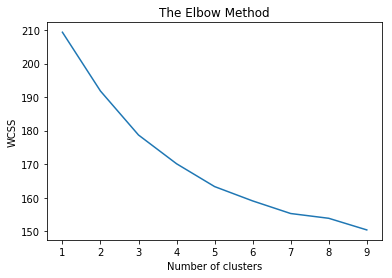

In [184]:
find_number_clusters(tfidf=cluster4_tfidif)

In [29]:
# trying to find subclusters for any cluster 
Subcluster4_df=merged_df[merged_df['Clusters']==4]
# to get only the indices for this cluster
cluster4_tfidif=tfidf_matrix[Subcluster4_df.index.values]
km,clusters = apply_kmeans(num_clusters = 2,random_state =10,tfidf = cluster4_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster4_df = Subcluster4_df.assign(Subclusters_level_1 = clusters)
# Printing terms per cluster
print_cluster(df=Subcluster4_df, km=km, num_clusters=2, num_cluster_topics=5, \
              num_cluster_companies=5, cluster_level='Subclusters_level_1')

#X_freq_terms, freq_terms_with_count = freq_words(indexes=Subcluster4_df.index.values,new_corpus=new_corpus,\
 #                                                terms=terms,X=3)
#print_cluster_words(df=Subcluster4_df, km=km, num_clusters=2, cluster_level='Subclusters_level_1',\
 #                   words=X_freq_terms , num_cluster_topics=3, num_cluster_companies=3)

Top terms per cluster:

Cluster 0 words: ga, natur ga, natur, electr, pipelin,

Cluster 0 Companies: Cheniere Energy, Inc., El Paso Electric Co., DTE Energy Company, Williams Companies, Inc., Natural Gas Services Group Inc.,

Cluster 1 words: oil, ga, natur ga, natur, oil natur ga,

Cluster 1 Companies: Eco-Stim Energy Solutions, Inc., Key Energy Services Inc., Hornbeck Offshore Services, Inc., ZaZa Energy Corporation, Eagle Materials Inc.,

Split of classes within clusters:
1    155
0    137
Name: Subclusters_level_1, dtype: int64


### Splitting cluster 1


In [33]:
# trying to find subclusters for any cluster 
Subcluster1_df=merged_df[merged_df['Clusters']==1]
# to get only the indices for this cluster
cluster1_tfidif=tfidf_matrix[Subcluster1_df.index.values]
km,clusters = apply_kmeans(num_clusters = 2,random_state =10,tfidf = cluster1_tfidif)
#len(clusters1)
# add new column which includes the numbers of the new clusters
Subcluster1_df = Subcluster1_df.assign(Subclusters_level_1 = clusters)
# Printing terms per cluster
#print_cluster(df=Subcluster1_df, km=km, num_clusters=2, num_cluster_topics=6, \
 #             num_cluster_companies=5, cluster_level='Subclusters_level_1')
X_freq_terms, freq_terms_with_count = freq_words(indexes=Subcluster1_df.index.values,new_corpus=new_corpus,\
                                                terms=terms,X=2)
print_cluster_words(df=Subcluster1_df, km=km, num_clusters=2, cluster_level='Subclusters_level_1',\
                    words=X_freq_terms , num_cluster_topics=3, num_cluster_companies=3)

Top terms per cluster:

Cluster 0 words: real estat, estat, properti,

Cluster 0 Companies: Terreno Realty Corp., AMREP Corporation, STORE Capital Corporation,

Cluster 1 words: equiti, incom, stock,

Cluster 1 Companies: JMP Group LLC, Adams Natural Resources Fund, Inc., Main Street Capital Corporation,

Split of classes within clusters:
0    215
1    145
Name: Subclusters_level_1, dtype: int64


In [34]:
#Combining Subclusters and adding into original dataframe
test=pd.concat([Subcluster1_df,Subcluster4_df,Subcluster3_df])
test.drop(['Country','Company','Sector','Industry','Clusters'], axis=1, inplace=True)
merged_df = pd.merge(left=merged_df, right=test, how='left', on="Ticker")

# Creating one more level of sub clusters

### Splitting cluster 3, subcluster 0 into more clusters

In [35]:
# trying to find subclusters for any cluster 
Subcluster3_level1_0_df = merged_df[(merged_df['Clusters']==3) & (merged_df['Subclusters_level_1']==0)]
# to get only the indices for this cluster
Subcluster3_level1_0_tfidif=tfidf_matrix[Subcluster3_level1_0_df.index.values]
km,clusters = apply_kmeans(num_clusters = 4,random_state =42,tfidf = Subcluster3_level1_0_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster3_level1_0_df = Subcluster3_level1_0_df.assign(Subclusters_level_2 = clusters)
# Printing terms per cluster
print_cluster(df=Subcluster3_level1_0_df, km=km, num_clusters=4, num_cluster_topics=5, \
              num_cluster_companies=5, cluster_level='Subclusters_level_2')

Top terms per cluster:

Cluster 0 words: payment, technolog, financi, inform, onlin,

Cluster 0 Companies: FleetCor Technologies, Inc., First Data Corporation, LivePerson Inc., Cass Information Systems, Inc., HealthEquity, Inc.,

Cluster 1 words: wireless, commun, network, video, voic,

Cluster 1 Companies: xG Technology, Inc., T-Mobile US, Inc., Telephone & Data Systems Inc., Fitbit Inc., ScanSource, Inc.,

Cluster 2 words: softwar, data, cloud, applic, enterpris,

Cluster 2 Companies: Qumu Corporation, Rennova Health, Inc., Tableau Software, Inc., ServiceSource International, Inc., WidePoint Corp.,

Cluster 3 words: digit, content, advertis, media, televis,

Cluster 3 Companies: Xerox Corporation, Daktronics Inc., Yelp Inc., Apple Inc., XO Group Inc.,

Split of classes within clusters:
2    170
0    153
1    119
3    113
Name: Subclusters_level_2, dtype: int64


### Splitting cluster 3, subcluster 2 into more clusters

In [36]:
# trying to find subclusters for any cluster 
Subcluster3_level1_2_df = merged_df[(merged_df['Clusters']==3) & (merged_df['Subclusters_level_1']==2)]
Subcluster3_level1_2_tfidif=tfidf_matrix[Subcluster3_level1_2_df.index.values]
km,clusters = apply_kmeans(num_clusters = 3,random_state =42,tfidf = Subcluster3_level1_2_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster3_level1_2_df = Subcluster3_level1_2_df.assign(Subclusters_level_2 = clusters)
# Printing terms per cluster
#print_cluster(df=Subcluster3_level1_2_df, km=km, num_clusters=3, num_cluster_topics=5, \
#              num_cluster_companies=5, cluster_level='Subclusters_level_2')
#removing X most frequent terms from parent cluster
X_freq_terms, freq_terms_with_count = freq_words(indexes=Subcluster3_level1_2_df.index.values,new_corpus=new_corpus,\
                                                 terms=terms,X=2)
print_cluster_words(df=Subcluster3_level1_2_df, km=km, num_clusters=3, cluster_level='Subclusters_level_2',\
                    words=X_freq_terms , num_cluster_topics=3, num_cluster_companies=3)

Top terms per cluster:

Cluster 0 words: food, care, health,

Cluster 0 Companies: Coffee Holding Company, Inc., Sysco Corporation, Nutrisystem, Inc.,

Cluster 1 words: accessori, apparel, women,

Cluster 1 Companies: Wolverine World Wide Inc., Ross Stores Inc., Trans World Entertainment Corporation,

Cluster 2 words: restaur, franchis, oper,

Cluster 2 Companies: The Habit Restaurants, Inc., Biglari Holdings Inc., Jamba, Inc.,

Split of classes within clusters:
0    663
1    137
2     44
Name: Subclusters_level_2, dtype: int64


### Splitting cluster 3, subcluster 1 into more clusters

In [37]:
Subcluster3_level1_1_df=merged_df[(merged_df['Clusters']==3) & (merged_df['Subclusters_level_1']==1)]
Subcluster3_level1_1_tfidif=tfidf_matrix[Subcluster3_level1_1_df.index.values]
km,clusters = apply_kmeans(num_clusters = 3,random_state =42,tfidf = Subcluster3_level1_1_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster3_level1_1_df = Subcluster3_level1_1_df.assign(Subclusters_level_2 = clusters)
# Printing terms per cluster
#print_cluster(df=Subcluster3_level1_1_df, km=km, num_clusters=3, num_cluster_topics=5, \
#              num_cluster_companies=3, cluster_level='Subclusters_level_2')
#removing X most frequent terms from parent cluster
X_freq_terms, freq_terms_with_count = freq_words(indexes=Subcluster3_level1_1_df.index.values,new_corpus=new_corpus,\
                                                 terms=terms,X=10)
print_cluster_words(df=Subcluster3_level1_1_df, km=km, num_clusters=3, cluster_level='Subclusters_level_2',\
                    words=X_freq_terms , num_cluster_topics=4, num_cluster_companies=2)

Top terms per cluster:

Cluster 0 words: medic, diagnost, surgic, instrument,

Cluster 0 Companies: Echo Therapeutics, Inc., IRadimed Corporation,

Cluster 1 words: electron, semiconductor, optic, aerospac,

Cluster 1 Companies: Taitron Components Inc., CVD Equipment Corporation,

Cluster 2 words: construct, materi, electr, chemic,

Cluster 2 Companies: Fenix Parts, Inc., Miller Industries Inc.,

Split of classes within clusters:
2    386
1    166
0    154
Name: Subclusters_level_2, dtype: int64


In [38]:
test=pd.concat([Subcluster3_level1_1_df,Subcluster3_level1_2_df,Subcluster3_level1_0_df])
test.drop(['Country','Company','Sector','Industry','Clusters','Subclusters_level_1'], axis=1, inplace=True)
merged_df = pd.merge(left=merged_df, right=test, how='left', on="Ticker")

 #check if new_merged_df is correct, if so then rename it to merged_df
merged_df.columns = ['Ticker', 'Company', 'Sector', 'Industry', 'Country', 'Clusters Level 0','Clusters Level 1', \
                         'Clusters Level 2']
#temp = merged_df[merged_df['Clusters Level 0']==3]
#temp = temp[temp['Clusters Level 1']==3]
#temp = temp[temp['Clusters Level 2']==3].info()



In [39]:
# See the dataframe with the 3 levels, level 0, level 1 and level 2
merged_df

,Ticker,Company,Sector,Industry,Country,Clusters Level 0,Clusters Level 1,Clusters Level 2
0,A,"Agilent Technologies, Inc.",Healthcare,Medical Laboratories & Research,USA,3,1.0,0.0
1,AA,Alcoa Inc.,Basic Materials,Aluminum,USA,3,2.0,0.0
2,AAC,"AAC Holdings, Inc.",Healthcare,Specialized Health Services,USA,3,2.0,0.0
3,AAL,American Airlines Group Inc.,Services,Major Airlines,USA,3,2.0,0.0
4,AAMC,Altisource Asset Management Corporation,Financial,Asset Management,USA,3,2.0,0.0
5,AAME,Atlantic American Corp.,Financial,Life Insurance,USA,3,3.0,NaN
6,AAN,"Aaron's, Inc.",Services,Rental & Leasing Services,USA,3,2.0,1.0
7,AAOI,"Applied Optoelectronics, Inc.",Technology,Semiconductor - Integrated Circuits,USA,3,1.0,1.0
8,AAON,AAON Inc.,Industrial Goods,General Building Materials,USA,3,1.0,2.0
9,AAP,Advance Auto Parts Inc.,Services,Auto Parts Stores,USA,3,1.0,2.0


In [139]:
# rough work
# to find the 1st common term for cluster 0
#terms[order_centroids[0,0]]
#merged_df[merged_df['Clusters']==i]["Company"][0:5].values.tolist()
#order_centroids shape is 4x360 ie., 360 features from tdidf and 4 clusters from KNN
#terms[order_centroids[0,14]]
#import random    
#my_randoms=[]    
#for i in range (10):    
    #my_randoms.append(random.randrange(1,3559,1))    
    #print (my_randoms)  
#my_randoms
#title1 = merged_df[merged_df['Clusters']==0]["Company"].sample(1).values.tolist()
#merged_df.Sector[merged_df.Company=="Independent Bank Corporation"].values[0]
# Take separate dataframe according to each cluster
#Cluster0=merged_df[merged_df.Clusters==0]
#Cluster1=merged_df[merged_df.Clusters==1]
#Cluster2=merged_df[merged_df.Clusters==2]
#Cluster3=merged_df[merged_df.Clusters==3]
#print("Cluster0:",Cluster0.Sector.mode()[0],":- % correct categories is ",round(len(Cluster0[Cluster0.Sector==Cluster0.Sector.mode()[0]])/len(Cluster0)*100,2))
#print("Cluster1:",Cluster1.Sector.mode()[0],":- % correct categories is ",round(len(Cluster1[Cluster1.Sector==Cluster1.Sector.mode()[0]])/len(Cluster1)*100,2))
#print("Cluster2:",Cluster2.Sector.mode()[0],":- % correct categories is ",round(len(Cluster2[Cluster2.Sector==Cluster2.Sector.mode()[0]])/len(Cluster2)*100,2))
#print("Cluster3:",Cluster3.Sector.mode()[0],":- % correct categories is ",round(len(Cluster3[Cluster3.Sector==Cluster3.Sector.mode()[0]])/len(Cluster3)*100,2))
#print() #add whitespace
#print() #add whitespace